# Mercedes testing time

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, make_union
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error

In [3]:
data_path = 'data'
train_df = pd.read_csv(f'{data_path}/train.csv')
test_df = pd.read_csv(f'{data_path}/test.csv')

In [4]:
train_df.shape

(4209, 378)

In [5]:
s = train_df.nunique()
one_val_cols = list(s[s==1].index)
print(f'columns having only 1 unique value:\n{one_val_cols}')

columns having only 1 unique value:
['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']


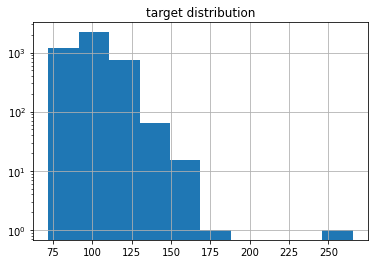

In [6]:
train_df.y.hist()
plt.title('target distribution')
plt.yscale('log')
plt.show()

In [7]:
# drop the outlier from training
clean_df = train_df.drop(train_df[train_df.y > 200].index)

# drop columns with 1 unique value
clean_df = clean_df.drop(columns=one_val_cols)
test_df = test_df.drop(columns=one_val_cols)

## Linear Regression

In [8]:
obj_cols = [col for col, dtype in train_df.dtypes.items() if dtype == 'object']

feature_pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), obj_cols),
    remainder='passthrough'),
    TruncatedSVD(random_state=0),
)

regressor = make_pipeline(
    feature_pipeline,
    Ridge(),
)

params = {
    'ridge__alpha': [35],
    'pipeline__truncatedsvd__n_components': [273],
    'pipeline__truncatedsvd__n_iter': [20],
}
results = GridSearchCV(
    estimator=regressor, 
    param_grid=params, 
    scoring='r2',
    cv=4,
    n_jobs=-1,
).fit(
    X=clean_df.drop(columns=['ID', 'y']), 
    y=clean_df['y'],
)

In [9]:
results.best_score_

0.5716308394047992

In [10]:
results.best_params_

{'pipeline__truncatedsvd__n_components': 273,
 'pipeline__truncatedsvd__n_iter': 20,
 'ridge__alpha': 35}

In [12]:
feature_pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), obj_cols),
    remainder='passthrough'),
    TruncatedSVD(
        n_components=results.best_params_['pipeline__truncatedsvd__n_components'], 
        n_iter=results.best_params_['pipeline__truncatedsvd__n_iter'], 
        random_state=0
    ),
)

regressor = make_pipeline(
    feature_pipeline,
    Ridge(alpha=results.best_params_['ridge__alpha']),
)

regressor.fit(
    X=clean_df.drop(columns=['ID', 'y']), 
    y=clean_df['y'],
)

test_df['y'] = regressor.predict(test_df.drop(columns=['ID']))

test_df[['ID', 'y']].to_csv('submission.csv', index=None)

## Gradient Boosting

In [14]:
from catboost import CatBoostRegressor, cv, Pool

In [19]:
pool = Pool(
    data=clean_df.drop(columns=['ID', 'y']),
    label=clean_df.y,
    cat_features=[col for col, dtype in clean_df.dtypes.items() if dtype == 'object']
)

In [33]:
params = {
    "iterations": 300,
    "loss_function": "RMSE",
    "learning_rate": 0.08,
    "depth": 4,
    "l2_leaf_reg": 2,
    "verbose": 1,
    "custom_metric": ['R2'],
}

### GridSearch some params

In [26]:
model = CatBoostRegressor(**params)

grid = {
    'learning_rate': np.arange(0.01, 0.1, 0.01),
    'depth': [3, 4, 5],
    'l2_leaf_reg': [1.0, 1.5, 2.0]
}

model.grid_search(
    param_grid=grid,
    X=pool,
    cv=4,
    plot=True,
    verbose=False,
)

### Check out the final params

In [45]:
cv(
    pool=pool,
    params=params,
    fold_count=4,
    plot=True,
    verbose=False,
)

### Submission

In [44]:
model = CatBoostRegressor(**params)
model.fit(X=pool, early_stopping_rounds=30, verbose=False)

test_df['y'] = model.predict(test_df.drop(columns=['ID', 'y']))

test_df[['ID', 'y']].to_csv('submission.csv', index=None) # 0.54948 on private leaderboard